In [1]:
import sys
sys.path.append("../../")

In [2]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import seaborn as sb
from autograd import grad
from uq360.utils.hidden_markov_model import HMM
from uq360.algorithms.infinitesimal_jackknife.infinitesimal_jackknife import InfinitesimalJackknife
%matplotlib inline

In this notebook, we will look at structured infinitesimal jackknife (IJ) approximations for cases where data are not independent across folds of the jackknife. We will illustrate this by leaving time-steps out of an hidden Markov model. 

The key difference between the hidden Markov model (HMM) and logistic regression (in demo_infinitesimal_jackknife) is that instead of a loss method, we have a weigted_loss method for HMMs. The weighted_loss accounts for weights on different sites within a strucutre. For temporal data modeled by a HMM, we assign weights $w_t$ to the observation $x_t$ at time-step $t$. The weighted_loss method then runs a weighted instance of belief propagation (also known as the forward algorithm for HMMs) to compute the appropriate loss. See https://arxiv.org/pdf/2006.12669.pdf (in particular Appendix D) for more details.    

Let us now use the IJ approximation to jackknife to get confidence intervals.

## Fit the model to simulated data

In [3]:
# generate simulated data
K = 2  # number of states
T = 1000 # number of time steps
D = 1 # dimensionality of the data
data = HMM.synthetic_hmm_data(K, T, D, diagonal_upweight=True, varainces_of_mean=2.0) # well separated states
inputs = data['X']
hmm_config_dict = {'K': K, 'precision': None}
hmm = HMM(inputs, config_dict=hmm_config_dict)

# Standard MLE model fit
T = inputs.shape[1]
weights_one = np.ones([T])
params_one = hmm.fit(weights_one)
H = hmm.compute_hessian(params_one, weights_one)
J = hmm.compute_jacobian(params_one, weights_one)

# Approximate Jackknife
config = {"alpha": 0.01, "resampling_strategy": 'jackknife'}
ij = InfinitesimalJackknife(params_one, J, H, config)

In [4]:
params_exact = params_one
param_dict_exact = hmm.unpack_params(params_exact)
print (data['means'], param_dict_exact['phi'])

[[ 1.21564159]
 [-0.90018017]] [[-0.87747702  1.20937082]]


## Is IJ an accurate approximation to Exact Jackknife?

First we will verify that infinitesimal jackknife is a good approximation to exact jackknife.
We will do so by running exact jackknife on a subset of the data and comparing with IJ.

Performing Exact JackKnife
Mean Absolute Deviation between approximate and exact jackknife:  0.017300137861213826


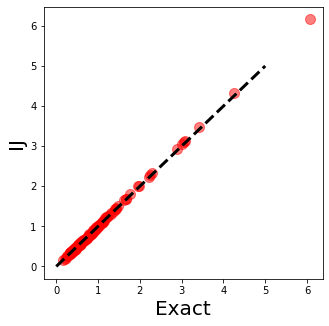

In [5]:
# compare approximate with exact jackknife for a few points
o = HMM.get_indices_in_held_out_fold(T=T, pct_to_drop=15, contiguous=True)
weights = np.ones([T])
weights[o] = 0
params_ij = ij.ij(weights.squeeze())
approx_loss = hmm.loss_at_missing_timesteps(weights, params=params_ij)
print ("Performing Exact JackKnife")
params_exact = hmm.fit(weights, init_params=params_one)  # exact params with warm start
exact_loss = hmm.loss_at_missing_timesteps(weights, params=params_exact)

plt.figure(figsize=(5,5))
plt.plot(exact_loss, approx_loss, 'ro', ms=10, alpha=0.5)
plt.plot([0, 5], [0, 5], 'k--', lw=3)
plt.xlabel("Exact", fontsize=20)
plt.ylabel("IJ", fontsize=20)

print("Mean Absolute Deviation between approximate and exact jackknife: ",
      np.mean(np.abs(exact_loss - approx_loss)))
assert np.allclose(exact_loss, approx_loss, atol=1e-1, rtol=1e-1)

As we can see, there is strong agreement between exact and approximate (IJ) jackknife.

## Predictive uncertainties 
Next, we will use IJ to get predictive uncertainties --- unceratinties in HMM sample paths.

In [6]:
def posterior_predictive_samples(hmm, param_dict, T=1000):
        npr.seed(24) # resetting seed ensures that different draws np.random.* are different only when the parameters are different
        pi0 = param_dict['pi0']
        phi = param_dict['phi']
        A = param_dict['A']
        K = hmm.K
        D = hmm.D
        C = 1./hmm.Precision # ASSUMES diagonal precisions
        zs = np.empty((T), dtype=np.int)
        X = np.empty((T, D))
        zs[0] = int(np.random.choice(np.arange(K), p=pi0))
        X[0] = np.random.multivariate_normal(mean=phi[:, zs[0]], cov=C[:, :, zs[0]]) 
        for t in range(1, T):
            zs[t] = int(np.random.choice(np.arange(K), p=A[zs[t - 1], :]))
            X[t] = np.random.multivariate_normal(mean=phi[:, zs[t]], cov=C[:, :, zs[t]])
        
        return X, zs

We will next use a 1000 delete-d jacknife folds (each fold will leave out d timesteps chosen at random from the original time series), use IJ to approximate the parameters for each fold and compute the resulting uncertainty in the data space. 

In [7]:
num_folds = 1000
ppred_signal_length = 50
x = np.empty([num_folds, ppred_signal_length])
z = np.empty([num_folds, ppred_signal_length], dtype=int)
mus = np.empty([num_folds, hmm.K])
A = np.empty([num_folds, hmm.K, hmm.K])
for n in np.arange(num_folds):
    np.random.seed(n)
    o = HMM.get_indices_in_held_out_fold(T=hmm.T, pct_to_drop=25, contiguous=False)
    weights = np.ones([T])
    weights[o] = 0
    params_ij = ij.ij(weights.squeeze())
    param_dict = hmm.unpack_params(params_ij)
    mus[n] = param_dict['phi']
    A[n] = param_dict['A']
    r = posterior_predictive_samples(hmm, param_dict, T=ppred_signal_length)
    x[n] = r[0].squeeze()
    z[n] = r[1].squeeze().astype(int)

First let's look at the uncertainity in the observation means of the two states.

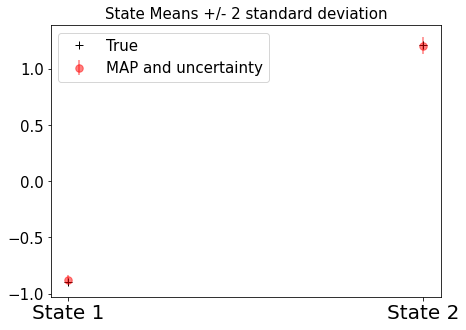

In [8]:
plt.figure(figsize=(7, 5))
std_mu = np.std(mus, axis=0)
plt.errorbar(x=[5, 7.5], y=param_dict_exact['phi'][0], yerr=2*std_mu, marker ='o', ms=7.5, ls='', 
             color='r', alpha=0.5, label='MAP and uncertainty')
plt.plot([5, 7.5], data['means'][::-1], 'k+', ms=7.5, label='True') # accounts for label switching --- states flipping because of inherent non-identifiabilityy
plt.xticks([5, 7.5], labels=['State 1', 'State 2'], fontsize=20)
plt.yticks(fontsize=15)
plt.title('State Means +/- 2 standard deviation', fontsize=15)
plt.legend(fontsize=15)



Next we will visualize the uncertainty in HMM sample paths. We will do this by setting the HMM parameters to the parameters approximated by IJ after leaving out each of the 1000 folds. For each paramter setting we will draw a single sample path (with a shared random seed). The variability in the sample paths provide a measure of the **epistemic uncertainty** --- uncertainty in the HMM parameters.

In [9]:
std_x = np.std(x, axis=0)
mean_x = np.mean(x, axis=0)

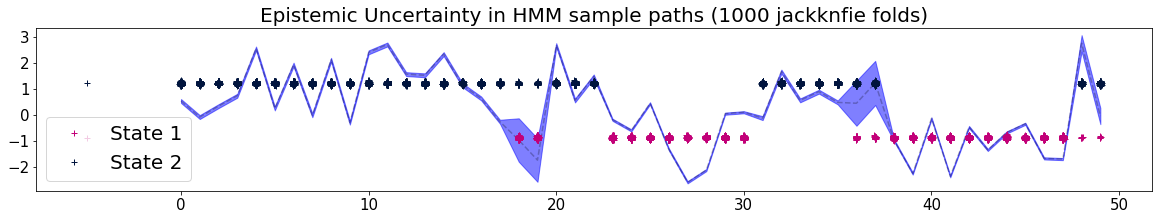

In [10]:
plt.figure(figsize=(20, 3))
plt_x = np.arange(ppred_signal_length)
plt.plot(mean_x, 'k--', alpha=0.25,)
plt.fill_between(plt_x, mean_x - 2 * std_x, mean_x + 2 *std_x, color='b', alpha=0.5)
cs = ['xkcd:magenta', 'xkcd:navy']
plt.plot(-5, param_dict_exact['phi'][0][0], '+', alpha=1., color=cs[0], label="State 1") 
plt.plot(-5, param_dict_exact['phi'][0][1], '+', alpha=1., color=cs[1], label="State 2") 
for n in np.arange(1000):
    for t in plt_x:
        plt.plot(t+2*1e-2*np.random.randn(), param_dict_exact['phi'][0][z[n, t]]+3*1e-2*np.random.randn(), '+', alpha=1., color=cs[z[n, t]]) # adds jitter to x and y axis
        
plt.title("Epistemic Uncertainty in HMM sample paths (1000 jackknfie folds)", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=20, loc="lower left")

For this simple problem, the uncertainty in the observation and transition parameters is small. However, when simulating from the learned model, small changes to the paramters can lead to changes in state assignments leading to larger predictive uncertainties. In the figure above, the black and magenta +s are plotted such that their x-coordinate corresponds to the time step and their y-coordinate corresponds to the means of the Gaussian distribution for each state. We plot a + for each time step (50 in all) within each sample path (1000 in all). Different paramters may assign the same time step to different states, this corresponds to the black and magenta +s sharing the same x-coordinate in the plot and typically results in higher uncertainty. 

We can additionally visualize the total uncertainty. As an approximation we simply add the two sources of uncertainty (aleatoric --- from the Gaussian observation model's variance and the epistemic uncertainty from our approximation to delete-d jackknfie via IJ). In the plot below we highlight the epistemic component of the total uncertainty.

No handles with labels found to put in legend.


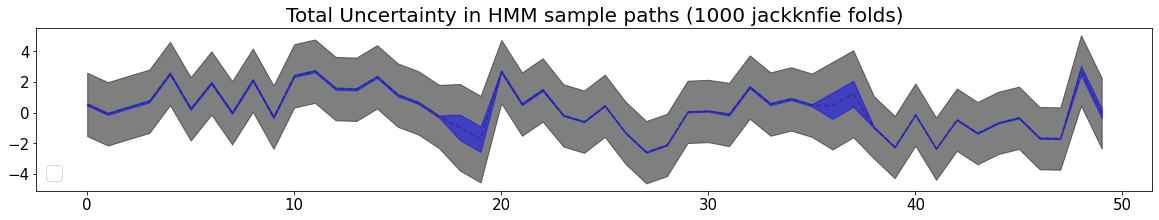

In [11]:
plt.figure(figsize=(20, 3))
plt_x = np.arange(ppred_signal_length)
plt.plot(mean_x, 'k--', alpha=0.25,)
plt.fill_between(plt_x, mean_x - 2 * std_x - 2 * np.sqrt(1./hmm.Precision.squeeze()[0]), mean_x + 2 *std_x + 2 * np.sqrt(1./hmm.Precision.squeeze()[0]), color='k', alpha=0.5)
plt.fill_between(plt_x, mean_x - 2 * std_x, mean_x + 2 * std_x, color='b', alpha=0.5)        

plt.title("Total Uncertainty in HMM sample paths (1000 jackknfie folds)", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=20, loc="lower left")